# **Spatial Patterns of insect Diversity in continetal Ecuador**

### **Data processing and cleaning**

Author: Daning Montaño - Ocampo

In this first part of the process, the biodiversity records are cleaned up to Genus Level

# **1. Packages and libraries**

In [3]:
library(dplyr)
library(bdc) ## data cleaning
library(lubridate)
library(stringr)
library(doParallel)
library(CoordinateCleaner)
library(purrr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Warning message:
package ‘dplyr’ was built under R version 4.3.3 
Warning message:
package ‘bdc’ was built under R version 4.3.3 



Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Warning message:
package ‘lubridate’ was built under R version 4.3.3 
Warning message:
package ‘stringr’ was built under R version 4.3.3 


Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


Warning message:
package ‘doParallel’ was built under R version 4.3.3 



Attaching package: ‘purrr’

The following objects are masked from ‘package:foreach’:

    accumulate, when



# **2. Load and homogenize Data**

We used data from:
- Global Biodiversity Information Facility (GBIF)
- PUCE - museum
- iDigBio
- Base nacional de datos de biodiversidad (BNDB)

To homogenize and clean the data from different databases we used "bdc" package. 

Metadata file contains the information of the different columns names of the databaases and assing a unique name in a single database.

In [4]:
metadata <- readr::read_delim("Data/Records/metadata.csv", delim = ";",show_col_types = FALSE)



Load the data using metadata file parameters

In [5]:
database<-
  bdc_standardize_datasets(metadata = metadata,
                           format = "csv",
                           overwrite = T,
                           save_database = T)




Standardizing IDIGBIO file
Standardizing BNDB file
Standardizing GBIF file
Standardizing PUCE file
C:/PROYECTOS/Spatial_patterns_insects/CODIGOS/Output/Intermediate/00_merged_database.csv was created


Warning messages:
1: One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat) 
2: One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat) 


Create a new column with the name of the data source

In [6]:

database$database_name =sub("_.*", "", database$database_id)
unique(database$database_name)

[1] "BNDB"    "GBIF"    "IDIGBIO" "PUCE"   

Since the Year variable is not created properly in the PUCE dataset, we use verbatimEventDate to create the values in Year only for the PUCE dataset.

In [7]:
idx <- str_trim(database$database_name) == "PUCE"
database$year[idx] <- as.integer(
  lubridate::year(lubridate::ymd_hms(as.character(database$verbatimEventDate[idx]),
                                     tz = "UTC", quiet = TRUE))
)

Inicial dimension of the dataset

In [8]:
dimension = database %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB           11342  2.80
2 GBIF          306290 75.7 
3 IDIGBIO        70236 17.4 
4 PUCE           16735  4.14

In [9]:
sum(dimension$n)

[1] 404603

# **3. Cleaning**

## 3.1. Clean repeated ocurrendIDs

In [10]:
database_1 = database %>%
  distinct(occurrenceID, .keep_all = TRUE)


In [11]:
database_1

# A tibble: 397,146 × 20
   database_id TaxonRank class   family     genus scientificName decimalLatitude decimalLongitude occurrenceID basisOfRecord verbatimEventDate country
   <chr>       <chr>     <chr>   <chr>      <chr> <chr>          <chr>           <chr>            <chr>        <chr>         <chr>             <chr>  
 1 BNDB_1      Genus     Insecta COLUBRIDAE Ninia Ninia          0.99508         -78.21735        25b0d36c-30… "Esp\xe9cime… 2021-08-05        Ecuador
 2 BNDB_2      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.036806       -78.765028       d2414fec-75… "Esp\xe9cime… 2017-04-17        Ecuador
 3 BNDB_3      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.069194       -78.761278       3ea86160-21… "Esp\xe9cime… 2017-04-17        Ecuador
 4 BNDB_4      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.033056       -78.755          de08a11c-8e… "Esp\xe9cime… 2017-04-17        Ecuador
 5 BNDB_5      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -3.5

In [12]:
dimension_1= database_1 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_1

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB           11342  2.86
2 GBIF          298838 75.2 
3 IDIGBIO        70231 17.7 
4 PUCE           16735  4.21

In [13]:
sum(dimension_1$n)

[1] 397146

## 3.2. Select only species level data

We only keeped data from Genus level, we filter using all the ways of species could be written.
NA values ara manteined despite the fact that they comes from BNDN data, wich does not have Taxon rank information, for this we delete using NA in taxon Name

In [14]:
unique(database_1$TaxonRank)

 [1] "Genus"       "Species"     "Family"      "Order"       "Subgenus"    "Suborder"    "SPECIES"     "GENUS"       "FAMILY"      "SUBSPECIES" 
[11] "ORDER"       "UNRANKED"    "CLASS"       NA            "Subfamily"   "order"       "family"      "tribe"       "genus"       "species"    
[21] "subfamily"   "Subspec"     "Tribe"       "class"       "Class"       "Subspecies"  "var."        "subspecies"  "superorder"  "superfamily"
[31] "subgenus"    "form"       

In [15]:
database_2 = database_1 %>%
  filter(TaxonRank %in% c( "Species","SPECIES" ,  "SUBSPECIES", "Subspecies", "species", "subspecies", "Species group", "Subspec",
          "Genus" , "Subgenus", "GENUS", "genus", "var.", "subgenus", NA))  %>%
  filter(!is.na(scientificName ))%>%
  filter(class=="Insecta")
database_2

# A tibble: 265,904 × 20
   database_id TaxonRank class   family     genus scientificName decimalLatitude decimalLongitude occurrenceID basisOfRecord verbatimEventDate country
   <chr>       <chr>     <chr>   <chr>      <chr> <chr>          <chr>           <chr>            <chr>        <chr>         <chr>             <chr>  
 1 BNDB_1      Genus     Insecta COLUBRIDAE Ninia Ninia          0.99508         -78.21735        25b0d36c-30… "Esp\xe9cime… 2021-08-05        Ecuador
 2 BNDB_2      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.036806       -78.765028       d2414fec-75… "Esp\xe9cime… 2017-04-17        Ecuador
 3 BNDB_3      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.069194       -78.761278       3ea86160-21… "Esp\xe9cime… 2017-04-17        Ecuador
 4 BNDB_4      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.033056       -78.755          de08a11c-8e… "Esp\xe9cime… 2017-04-17        Ecuador
 5 BNDB_5      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -3.5

In [16]:
dimension_2 = database_2 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_2

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8964  3.37
2 GBIF          190854 71.8 
3 IDIGBIO        49351 18.6 
4 PUCE           16735  6.29

In [17]:
sum(dimension_2$n)

[1] 265904

## 3.4 Filter date (1970 - 2024)

Exploration of year variable

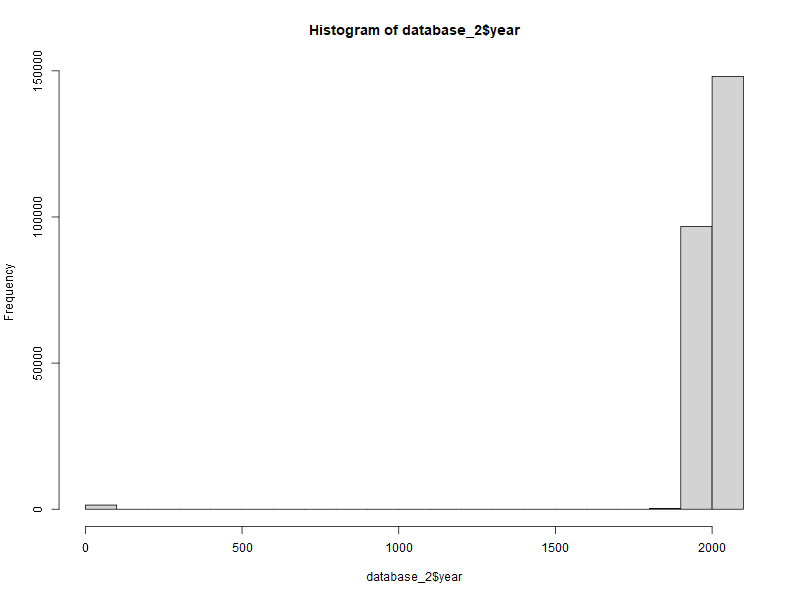

In [18]:
database_2$year = as.numeric(database_2$year)
hist(database_2$year)


Filtering 1970 - 2024

In [19]:
min(na.omit(database_2$year))

[1] 0

In [20]:
max(na.omit(database_2$year))

[1] 2024

In [21]:
database_3 = database_2 %>%
  filter(!is.na(year)) %>%
  filter(year >= 1970) %>%
  filter(year <= 2024) 

In [22]:
database_3

# A tibble: 240,554 × 20
   database_id TaxonRank class   family     genus scientificName decimalLatitude decimalLongitude occurrenceID basisOfRecord verbatimEventDate country
   <chr>       <chr>     <chr>   <chr>      <chr> <chr>          <chr>           <chr>            <chr>        <chr>         <chr>             <chr>  
 1 BNDB_1      Genus     Insecta COLUBRIDAE Ninia Ninia          0.99508         -78.21735        25b0d36c-30… "Esp\xe9cime… 2021-08-05        Ecuador
 2 BNDB_2      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.036806       -78.765028       d2414fec-75… "Esp\xe9cime… 2017-04-17        Ecuador
 3 BNDB_3      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.069194       -78.761278       3ea86160-21… "Esp\xe9cime… 2017-04-17        Ecuador
 4 BNDB_4      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.033056       -78.755          de08a11c-8e… "Esp\xe9cime… 2017-04-17        Ecuador
 5 BNDB_5      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -3.5

In [23]:
dimension_3 = database_3 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_3

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8607  3.58
2 GBIF          174002 72.3 
3 IDIGBIO        41299 17.2 
4 PUCE           16646  6.92

In [24]:
sum(dimension_3$n)

[1] 240554

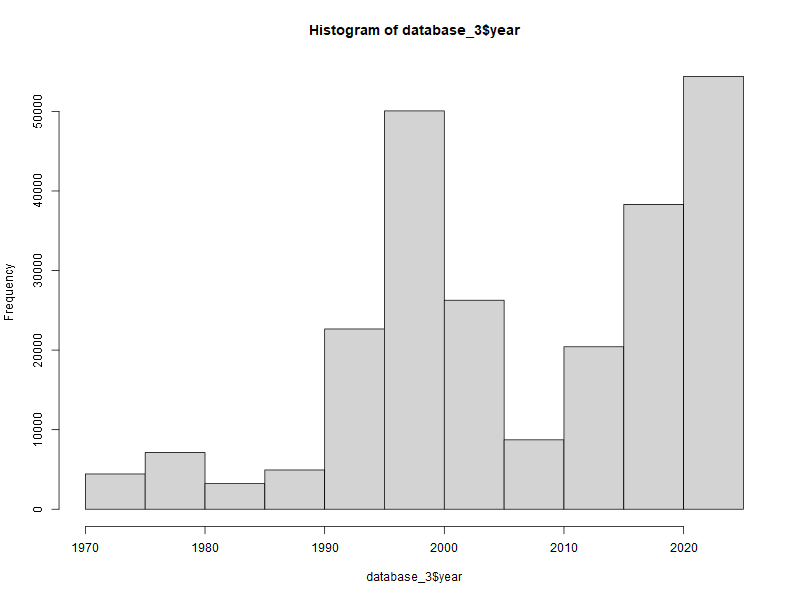

In [25]:
hist(database_3$year)

## 3.3. Delete Empy coordinates

In [26]:
database_4 = database_3 %>% 
  filter(!is.na(decimalLatitude)) %>% 
  filter(!is.na(decimalLongitude)) 

In [27]:
database_4

# A tibble: 240,554 × 20
   database_id TaxonRank class   family     genus scientificName decimalLatitude decimalLongitude occurrenceID basisOfRecord verbatimEventDate country
   <chr>       <chr>     <chr>   <chr>      <chr> <chr>          <chr>           <chr>            <chr>        <chr>         <chr>             <chr>  
 1 BNDB_1      Genus     Insecta COLUBRIDAE Ninia Ninia          0.99508         -78.21735        25b0d36c-30… "Esp\xe9cime… 2021-08-05        Ecuador
 2 BNDB_2      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.036806       -78.765028       d2414fec-75… "Esp\xe9cime… 2017-04-17        Ecuador
 3 BNDB_3      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.069194       -78.761278       3ea86160-21… "Esp\xe9cime… 2017-04-17        Ecuador
 4 BNDB_4      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.033056       -78.755          de08a11c-8e… "Esp\xe9cime… 2017-04-17        Ecuador
 5 BNDB_5      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -3.5

In [28]:
dimension_4 = database_4 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_4

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8607  3.58
2 GBIF          174002 72.3 
3 IDIGBIO        41299 17.2 
4 PUCE           16646  6.92

In [29]:
sum(dimension_4$n)

[1] 240554

## 3.5. Filter coordinates out of range

The funtions from bdc packages add flags to the data frame to indicate if there is a problem with the data

In [30]:
database_5 = bdc_coordinates_outOfRange(data = database_4, 
lat = "decimalLatitude",
lon = "decimalLongitude") %>%
  filter(.coordinates_outOfRange == TRUE)

database_5


bdc_coordinates_outOfRange:
Flagged 0 records.
One column was added to the database.



# A tibble: 240,554 × 21
   database_id TaxonRank class   family     genus scientificName decimalLatitude decimalLongitude occurrenceID basisOfRecord verbatimEventDate country
   <chr>       <chr>     <chr>   <chr>      <chr> <chr>          <chr>           <chr>            <chr>        <chr>         <chr>             <chr>  
 1 BNDB_1      Genus     Insecta COLUBRIDAE Ninia Ninia          0.99508         -78.21735        25b0d36c-30… "Esp\xe9cime… 2021-08-05        Ecuador
 2 BNDB_2      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.036806       -78.765028       d2414fec-75… "Esp\xe9cime… 2017-04-17        Ecuador
 3 BNDB_3      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.069194       -78.761278       3ea86160-21… "Esp\xe9cime… 2017-04-17        Ecuador
 4 BNDB_4      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.033056       -78.755          de08a11c-8e… "Esp\xe9cime… 2017-04-17        Ecuador
 5 BNDB_5      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -3.5

In [31]:
dimension_5 = database_5 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_5

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8607  3.58
2 GBIF          174002 72.3 
3 IDIGBIO        41299 17.2 
4 PUCE           16646  6.92

In [32]:
sum(dimension_5$n)

[1] 240554

## 3.6. Filter coordinate Uncertainty

We only keep records with an accuracy of less than 10 km. If the value is NA, it is retained and other types of spatial filters are applied in the following steps.

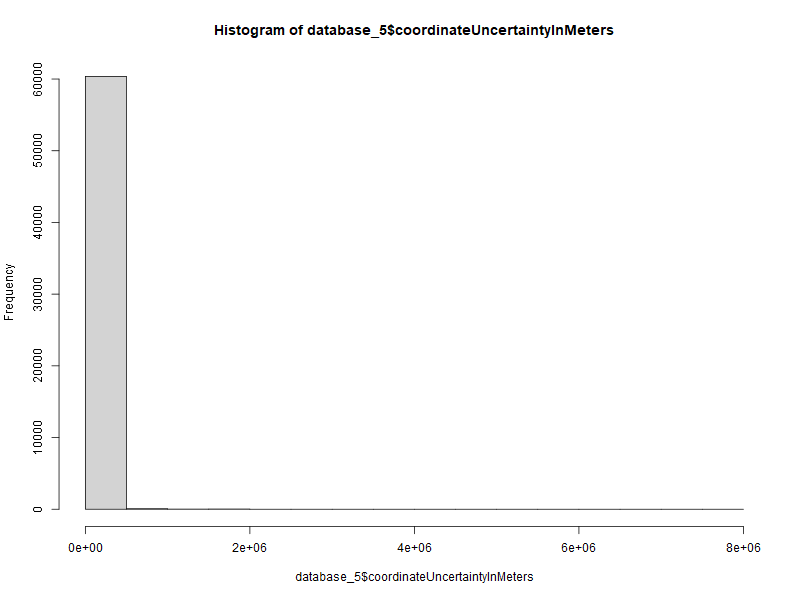

In [33]:
database_5$coordinateUncertaintyInMeters = as.numeric(database_5$coordinateUncertaintyInMeters)
hist(database_5$coordinateUncertaintyInMeters)

In [34]:
database_6 = database_5%>%
  filter(coordinateUncertaintyInMeters <= 100000| is.na(coordinateUncertaintyInMeters))

database_6

# A tibble: 239,523 × 21
   database_id TaxonRank class   family     genus scientificName decimalLatitude decimalLongitude occurrenceID basisOfRecord verbatimEventDate country
   <chr>       <chr>     <chr>   <chr>      <chr> <chr>          <chr>           <chr>            <chr>        <chr>         <chr>             <chr>  
 1 BNDB_1      Genus     Insecta COLUBRIDAE Ninia Ninia          0.99508         -78.21735        25b0d36c-30… "Esp\xe9cime… 2021-08-05        Ecuador
 2 BNDB_2      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.036806       -78.765028       d2414fec-75… "Esp\xe9cime… 2017-04-17        Ecuador
 3 BNDB_3      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.069194       -78.761278       3ea86160-21… "Esp\xe9cime… 2017-04-17        Ecuador
 4 BNDB_4      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -0.033056       -78.755          de08a11c-8e… "Esp\xe9cime… 2017-04-17        Ecuador
 5 BNDB_5      Species   Insecta COLUBRIDAE Ninia Ninia atrata   -3.5

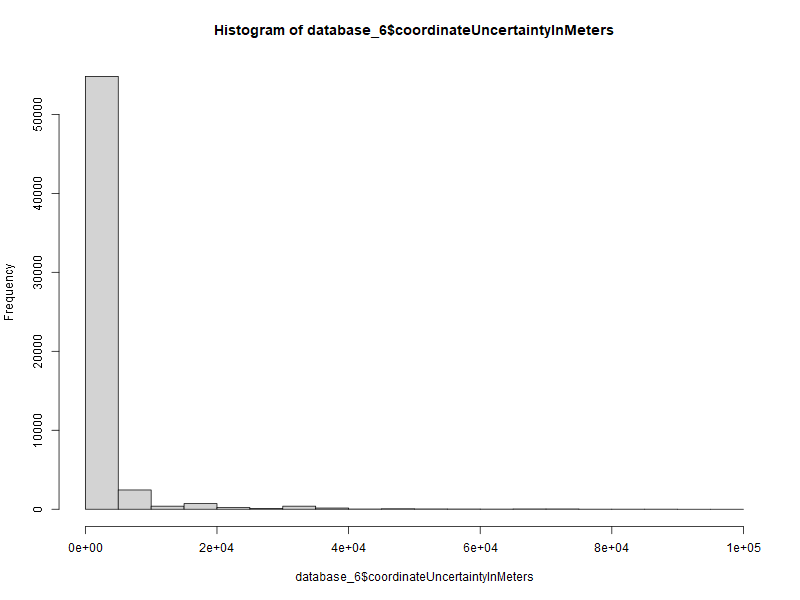

In [35]:
hist(database_6$coordinateUncertaintyInMeters)

In [36]:
dimension_6 = database_6 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_6

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8607  3.59
2 GBIF          173380 72.4 
3 IDIGBIO        40890 17.1 
4 PUCE           16646  6.95

In [37]:
sum(dimension_6$n)

[1] 239523

database_6

## 3.7. Classify only Genus and uncertainties

In [41]:
identify_uncert <- function(name) {
  uncer_terms <- FALSE
  infraesp_names <- FALSE
  generic_only <- FALSE
  
  # Incertidumbre ("cf.", "aff.", "?", "nr.", "indet.", "undet")
  if (grepl("\\b(cf\\.?|aff\\.?|nr\\.?|indet\\.?|undet\\.?|\\?)\\b", name, ignore.case = TRUE)) {
    uncer_terms <- TRUE
  }
  

  
  # Género sin especie ("sp.", "spp.")
 # if (grepl("\\b(sp\\.|spp\\.)\\b", name, ignore.case = TRUE)) {
  #  generic_only <- TRUE
  #}
  
  return(list(
    name = name,
    uncer_terms = uncer_terms

    #generic_only = generic_only
  ))
}


In [42]:
sp_names = unique(database_6$scientificName)
uncertain_results <- map(sp_names , identify_uncert)
uncertain_results_df <- do.call(rbind, lapply(uncertain_results, as.data.frame))
uncertain_results_df

There were 50 or more warnings (use warnings() to see the first 50)


                             name uncer_terms
1                           Ninia       FALSE
2                    Ninia atrata       FALSE
3                   Ninia hudsoni       FALSE
4                    Acanthagrion       FALSE
5                          Aeshna       FALSE
6                    Agriogomphus       FALSE
7                    Alluaudomyia       FALSE
8                      Alotanypus       FALSE
9                        Ambrysus       FALSE
10                  Americabaetis       FALSE
11                  Amphoropsyche       FALSE
12                   Anacroneuria       FALSE
13                           Anax       FALSE
14                    Anchytarsus       FALSE
15                      Ancyronyx       FALSE
16                      Andesiops       FALSE
17               Anomalocosmoecus       FALSE
18                  Anomalopsyche       FALSE
19                     Aphrosylus       FALSE
20                        Aphylla       FALSE
21                      Apobaetis 

In [43]:
database_7 = database_6 %>%
  left_join(uncertain_results_df, by = c("scientificName" = "name"))%>%
  filter(uncer_terms == FALSE)# %>%
  #filter(generic_only == FALSE)


as.data.frame(database_7)

   database_id TaxonRank   class         family        genus scientificName decimalLatitude decimalLongitude                         occurrenceID
1       BNDB_1     Genus Insecta     COLUBRIDAE        Ninia          Ninia         0.99508        -78.21735 25b0d36c-305f-4272-b1b1-cb6a1bf17444
2       BNDB_2   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata       -0.036806       -78.765028 d2414fec-7512-43d2-91a6-1f2a20ea3121
3       BNDB_3   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata       -0.069194       -78.761278 3ea86160-2170-4501-abdf-194d28cb7694
4       BNDB_4   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata       -0.033056          -78.755 de08a11c-8eac-4498-bf2d-d12f17dd0cda
5       BNDB_5   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata    -3.579464169     -79.86111617 687d5977-9225-42b8-bb03-fb06da0f5d87
6       BNDB_8   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata        0.696947       -80.018614 4cfa9151-9541-4

In [44]:
dimension_7 = database_7 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_7

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8607  3.60
2 GBIF          173246 72.4 
3 IDIGBIO        40837 17.1 
4 PUCE           16646  6.96

In [45]:
sum(dimension_7$n)

[1] 239336

## 3.8. Cleaning names

In [46]:
genus_names = unique(database_7$genus)
genus_names_clean = bdc_clean_names(
  genus_names,
  save_outputs = FALSE
)


>> Family names prepended to scientific names were flagged and removed from 1 records.
>> Terms denoting taxonomic uncertainty were flagged and removed from 0 records.
>> Other issues, capitalizing the first letter of the generic name, replacing empty names by NA, and removing extra spaces, were flagged and corrected or removed from 1 records.
>> Infraspecific terms were flagged and removed from 0 records.



In [48]:
as.data.frame(genus_names_clean)

      scientificName .uncer_terms .infraesp_names      names_clean quality
1              Ninia         TRUE            TRUE            Ninia       1
2       Acanthagrion         TRUE            TRUE     Acanthagrion       1
3             Aeshna         TRUE            TRUE           Aeshna       1
4       Agriogomphus         TRUE            TRUE     Agriogomphus       1
5       Alluaudomyia         TRUE            TRUE     Alluaudomyia       1
6         Alotanypus         TRUE            TRUE       Alotanypus       1
7           Ambrysus         TRUE            TRUE         Ambrysus       1
8      Americabaetis         TRUE            TRUE    Americabaetis       1
9      Amphoropsyche         TRUE            TRUE    Amphoropsyche       1
10      Anacroneuria         TRUE            TRUE     Anacroneuria       1
11              Anax         TRUE            TRUE             Anax       1
12       Anchytarsus         TRUE            TRUE      Anchytarsus       1
13         Ancyronyx     

0 → Not interpretable (name could not be parsed).

1 → No problems detected (clean, valid name).

2 → Minor issues (uncertainty terms or small variants, but cleaned successfully).

3 → Moderate issues (complex authorship, ambiguous notation, partially resolved).

4 → Serious problems (multiple inconsistencies, requires manual review).

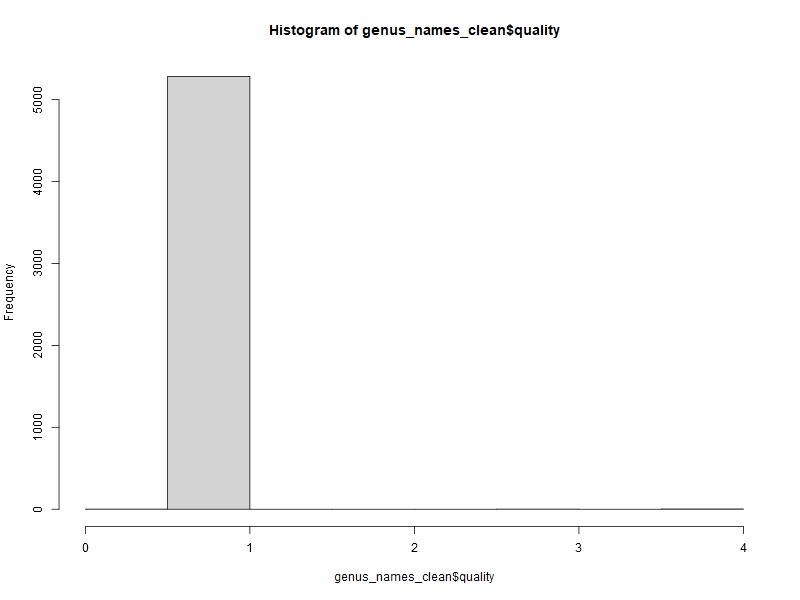

In [50]:
hist(genus_names_clean$quality)

Join clean scientific names with dataframe with all date

In [53]:
database_8 = database_7 %>%
  left_join(genus_names_clean, by = c("genus" = "scientificName"))%>%
  filter(quality %in% c(1, 2, 3))


as.data.frame(database_8)

   database_id TaxonRank   class         family        genus scientificName decimalLatitude decimalLongitude                         occurrenceID
1       BNDB_1     Genus Insecta     COLUBRIDAE        Ninia          Ninia         0.99508        -78.21735 25b0d36c-305f-4272-b1b1-cb6a1bf17444
2       BNDB_2   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata       -0.036806       -78.765028 d2414fec-7512-43d2-91a6-1f2a20ea3121
3       BNDB_3   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata       -0.069194       -78.761278 3ea86160-2170-4501-abdf-194d28cb7694
4       BNDB_4   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata       -0.033056          -78.755 de08a11c-8eac-4498-bf2d-d12f17dd0cda
5       BNDB_5   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata    -3.579464169     -79.86111617 687d5977-9225-42b8-bb03-fb06da0f5d87
6       BNDB_8   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata        0.696947       -80.018614 4cfa9151-9541-4

In [54]:
dimension_8 = database_8 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_8

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8136  3.62
2 GBIF          173246 77.0 
3 IDIGBIO        27040 12.0 
4 PUCE           16515  7.34

In [56]:
sum(dimension_8$n)

[1] 224937

## 3.9. Coordinate precision

1 decimal is aprox 11 km of precision 

In [57]:
database_9 <-
  bdc_coordinates_precision(
    data = database_8,
    lon = "decimalLongitude",
    lat = "decimalLatitude",
    ndec = c(1) # number of decimals to be tested
  )%>%
  filter( .rou == TRUE)
database_9


bdc_coordinates_precision:
Flagged 1607 records
One column was added to the database.



In [58]:
dimension_9 = database_9 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_9

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            8129  3.64
2 GBIF          172048 77.0 
3 IDIGBIO        26869 12.0 
4 PUCE           16284  7.29

In [59]:
sum(dimension_9$n)

[1] 223330

## 3.10. Cooordinate cleaner

We filtered the dataset to keep only records that passed the tests for capitals (.cap), centroids (.cen), and outliers (.otl).

- cap → removes records with capitals that are not the main capital of the country.

- cen → removes records near administrative centroids (country or province centroids assigned by default).

- otl → removes geographic outliers that are far from the main distribution of the species.

This ensures that only records with reliable geographic positions remain, reducing the risk of biased results in downstream analyses.

In [60]:
database_9$decimalLatitude = as.numeric(database_9$decimalLatitude)
database_9$decimalLongitude = as.numeric(database_9$decimalLongitude)

In [62]:
database_10 <- CoordinateCleaner::clean_coordinates(
  x       = database_9,
  lon     = "decimalLongitude",
  lat     = "decimalLatitude",
  species = "scientificName",
  tests   = c(
    "capitals",     # cerca de capitales
    "centroids",    # cerca de centroides adm. (país/provincia)
    "institutions", # cerca de instituciones (museos, herbarios, zoos)
    "outliers"    # outliers geográficos por especie
  ),
  capitals_rad      = 100,
  centroids_rad     = 100,
  centroids_detail  = "both",   # país y provincia
  inst_rad          = 100,
  outliers_method   = "quantile",
  outliers_mtp      = 10,
  outliers_td       = 1000,
  outliers_size     = 10,
  zeros_rad         = 0.5
)

database_10

Testing coordinate validity
Flagged 0 records.
Testing country capitals
Flagged 11 records.
Testing country centroids
Flagged 0 records.
Testing geographic outliers
Flagged 3964 records.
Testing biodiversity institutions
Flagged 278 records.
Flagged 1324 of 223330 records, EQ = 0.01.


Warning message:
In cc_outl(otl_test, lon = lon, lat = lat, species = species, method = outliers_method,  :
  Species with fewer than 7 unique records will not be tested.


   database_id TaxonRank   class         family        genus scientificName decimalLatitude decimalLongitude                         occurrenceID
1       BNDB_1     Genus Insecta     COLUBRIDAE        Ninia          Ninia       0.9950800        -78.21735 25b0d36c-305f-4272-b1b1-cb6a1bf17444
2       BNDB_2   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata      -0.0368060        -78.76503 d2414fec-7512-43d2-91a6-1f2a20ea3121
3       BNDB_3   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata      -0.0691940        -78.76128 3ea86160-2170-4501-abdf-194d28cb7694
4       BNDB_4   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata      -0.0330560        -78.75500 de08a11c-8eac-4498-bf2d-d12f17dd0cda
5       BNDB_5   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata      -3.5794642        -79.86112 687d5977-9225-42b8-bb03-fb06da0f5d87
6       BNDB_8   Species Insecta     COLUBRIDAE        Ninia   Ninia atrata       0.6969470        -80.01861 4cfa9151-9541-4

Filter data based in flags asigened 

In [63]:
database_10 = database_10 %>%
  filter(.cap == TRUE) %>%
  filter(.cen == TRUE) %>%
  filter(.otl == TRUE)

In [64]:
dimension_10 = database_10 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_10

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB            7094  3.19
2 GBIF          172042 77.4 
3 IDIGBIO        26864 12.1 
4 PUCE           16284  7.33

In [65]:
sum(dimension_10$n)

[1] 222284

Delete variables generated in data cleaning process

In [66]:
database_10 = database_10 %>%
  select(c(-.rou,-.val, -.cap, -.cen,-.otl , - .inst ,- .summary))


## 3.11. Validation of taxonomic names

Transform sub species to species level

In [ ]:
#sp_names = unique(database_10$names_clean)

#df_sp_level <- tibble(
#  original = sp_names,
#  Species_level = str_extract(sp_names, "^\\S+\\s+\\S+")
#)


#database_10 = database_10 %>%
#  left_join(df_sp_level, by = c("names_clean" = "original")) ## Join data


Using GBIF db

In [73]:

unique_names = unique(database_10$names_clean)
query_names <- bdc_query_names_taxadb(
  sci_name            = unique_names,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "gbif" , # taxonomic database
  rank_name           = "Insecta", # a taxonomic rank
  rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using gbif database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 5262 names queried in 1.1 minutes



In [74]:
query_names_gbif = query_names %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )


as.data.frame(query_names_gbif)

    original_search distance    notes      taxonID   scientificName taxonRank taxonomicStatus  kingdom     phylum   class         order
1       Anchytarsus       NA accepted GBIF:1033846      Anchytarsus     genus        accepted Animalia Arthropoda Insecta    Coleoptera
2         Ancyronyx       NA accepted GBIF:1033499        Ancyronyx     genus        accepted Animalia Arthropoda Insecta    Coleoptera
3         Andesiops       NA accepted GBIF:4683703        Andesiops     genus        accepted Animalia Arthropoda Insecta Ephemeroptera
4  Anomalocosmoecus       NA accepted GBIF:1442062 Anomalocosmoecus     genus        accepted Animalia Arthropoda Insecta   Trichoptera
5        Aphrosylus       NA accepted GBIF:1609134       Aphrosylus     genus        accepted Animalia Arthropoda Insecta       Diptera
6           Aphylla       NA accepted GBIF:1425745          Aphylla     genus        accepted Animalia Arthropoda Insecta       Odonata
7         Apobaetis       NA accepted GBIF:14079

In [75]:
notes_sum_gbif = query_names_gbif%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_gbif

# A tibble: 9 × 3
  notes                                         n    prop
  <chr>                                     <int>   <dbl>
1 accepted                                   4995 94.9   
2 accepted | replaceSynonym                    22  0.418 
3 accepted | wasMisspelled                     73  1.39  
4 accepted | wasMisspelled | replaceSynonym    21  0.399 
5 multipleAccepted                             53  1.01  
6 notFound                                     89  1.69  
7 proparte synonym                              2  0.0380
8 synonym                                       4  0.0760
9 synonym | wasMisspelled                       3  0.0570

Using Catalogue of Life to complement the list of species not accepted by GBIF

In [76]:
not_accepted_gbif = query_names_gbif %>% filter(notes %in% c("heterotypic synonym", "heterotypic synonym | wasMisspelled",
"homotypic synonym", "homotypic synonym | wasMisspelled", "multipleAccepted", "notFound", "synonym", "synonym | wasMisspelled", "NA",
"proparte synonym","synonym", "synonym | wasMisspelled" ))

summary_not_gbif = not_accepted_gbif %>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

summary_not_gbif

# A tibble: 5 × 3
  notes                       n  prop
  <chr>                   <int> <dbl>
1 multipleAccepted           53 35.1 
2 notFound                   89 58.9 
3 proparte synonym            2  1.32
4 synonym                     4  2.65
5 synonym | wasMisspelled     3  1.99

In [77]:

unique_names_col = unique(not_accepted_gbif$original_search)
query_names_col <- bdc_query_names_taxadb(
  sci_name            = unique_names_col,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "col" , # taxonomic database
  rank_name           = "Insecta", # a taxonomic rank
  rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using col database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 151 names queried in 1.3 minutes



In [78]:
query_names_col = query_names_col %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )


as.data.frame(query_names_col)

   original_search distance                                     notes   taxonID       scientificName taxonRank taxonomicStatus  kingdom   phylum
1        Leptonema     0.82 accepted | wasMisspelled | replaceSynonym COL:3TRRB    Ceratobornia cema   species        accepted Animalia Mollusca
2      Mortoniella       NA                                  notFound      <NA>                 <NA>      <NA>            <NA>     <NA>     <NA>
3       Petrophila       NA                                  notFound      <NA>                 <NA>      <NA>            <NA>     <NA>     <NA>
4           Phenax       NA                                  notFound      <NA>                 <NA>      <NA>            <NA>     <NA>     <NA>
5      Hydrophilus       NA                                  notFound      <NA>                 <NA>      <NA>            <NA>     <NA>     <NA>
6        Stigmella       NA                                  notFound      <NA>                 <NA>      <NA>            <NA>    

In [79]:
notes_sum_col = query_names_col%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_col

# A tibble: 2 × 3
  notes                                         n  prop
  <chr>                                     <int> <dbl>
1 accepted | wasMisspelled | replaceSynonym     2  1.32
2 notFound                                    149 98.7 

Using Integrated Taxonomic Information System  to complement the list of species not accepted by COL

In [80]:
not_accepted_col = query_names_col %>% filter(notes %in% c("ambiguous synonym", "ambiguous synonym | wasMisspelled",
"notFound", "accepted | wasMisspelled | replaceSynonym"))

not_accepted_col 

# A tibble: 151 × 14
   original_search distance notes             taxonID scientificName taxonRank taxonomicStatus kingdom phylum class order family genus specificEpithet
   <chr>              <dbl> <chr>             <chr>   <chr>          <chr>     <chr>           <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>          
 1 Leptonema           0.82 accepted | wasMi… COL:3T… Ceratobornia … species   accepted        Animal… Mollu… Biva… Gale… Lasae… Cera… cema           
 2 Mortoniella        NA    notFound          NA      NA             NA        NA              NA      NA     NA    NA    NA     NA    NA             
 3 Petrophila         NA    notFound          NA      NA             NA        NA              NA      NA     NA    NA    NA     NA    NA             
 4 Phenax             NA    notFound          NA      NA             NA        NA              NA      NA     NA    NA    NA     NA    NA             
 5 Hydrophilus        NA    notFound          NA      NA             NA  

In [81]:

unique_names_itis = unique(not_accepted_col$original_search)
query_names_itis <- bdc_query_names_taxadb(
  sci_name            = unique_names_itis,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "itis" , # taxonomic database
  rank_name           = "Insecta", # a taxonomic rank
  rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using itis database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 151 names queried in 0.3 minutes



In [82]:
query_names_itis = query_names_itis %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )


as.data.frame(query_names_itis)

   original_search distance                                     notes      taxonID scientificName taxonRank taxonomicStatus kingdom phylum class
1        Leptonema       NA                          multipleAccepted         <NA>           <NA>      <NA>            <NA>    <NA>   <NA>  <NA>
2      Mortoniella       NA                                  accepted  ITIS:598606    Mortoniella     genus        accepted    <NA>   <NA>  <NA>
3       Petrophila       NA                                  accepted  ITIS:117682     Petrophila     genus        accepted    <NA>   <NA>  <NA>
4           Phenax       NA                                  accepted  ITIS:822745         Phenax     genus        accepted    <NA>   <NA>  <NA>
5      Hydrophilus       NA                                  accepted  ITIS:113204    Hydrophilus     genus        accepted    <NA>   <NA>  <NA>
6        Stigmella       NA                                  notFound         <NA>           <NA>      <NA>            <NA>    <NA

In [83]:
notes_sum_itis = query_names_itis%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_itis

# A tibble: 6 × 3
  notes                                         n  prop
  <chr>                                     <int> <dbl>
1 accepted                                     33 21.9 
2 accepted | replaceSynonym                     3  1.99
3 accepted | wasMisspelled                     11  7.28
4 accepted | wasMisspelled | replaceSynonym     6  3.97
5 multipleAccepted                             10  6.62
6 notFound                                     88 58.3 

Join all taxa search results

In [84]:
querys_join = rbind(query_names_gbif, query_names_col, query_names_itis) 
querys_join = querys_join%>%distinct(scientificName, .keep_all = TRUE)
summary_taxon_querys = querys_join%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

summary_taxon_querys

# A tibble: 7 × 3
  notes                                         n    prop
  <chr>                                     <int>   <dbl>
1 accepted                                   5024 97.7   
2 accepted | replaceSynonym                    15  0.292 
3 accepted | wasMisspelled                     71  1.38  
4 accepted | wasMisspelled | replaceSynonym    26  0.505 
5 multipleAccepted                              1  0.0194
6 synonym                                       4  0.0778
7 synonym | wasMisspelled                       3  0.0583

In [85]:
querys_join 

# A tibble: 5,144 × 14
   original_search  distance notes    taxonID      scientificName   taxonRank taxonomicStatus kingdom  phylum class order family genus specificEpithet
   <chr>               <dbl> <chr>    <chr>        <chr>            <chr>     <chr>           <chr>    <chr>  <chr> <chr> <chr>  <chr> <chr>          
 1 Anchytarsus            NA accepted GBIF:1033846 Anchytarsus      genus     accepted        Animalia Arthr… Inse… Cole… Ptilo… Anch… NA             
 2 Ancyronyx              NA accepted GBIF:1033499 Ancyronyx        genus     accepted        Animalia Arthr… Inse… Cole… Elmid… Ancy… NA             
 3 Andesiops              NA accepted GBIF:4683703 Andesiops        genus     accepted        Animalia Arthr… Inse… Ephe… Baeti… Ande… NA             
 4 Anomalocosmoecus       NA accepted GBIF:1442062 Anomalocosmoecus genus     accepted        Animalia Arthr… Inse… Tric… Limne… Anom… NA             
 5 Aphrosylus             NA accepted GBIF:1609134 Aphrosylus       gen

In [87]:
database_10$id_record = seq(1:nrow(database_10))
database_11 = database_10 %>% left_join(querys_join, by = c("names_clean" = "original_search")) %>% distinct(id_record, .keep_all = TRUE)
database_11_sum_notes = database_11%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

database_11_sum_notes

Warning message:
In left_join(., querys_join, by = c(names_clean = "original_search")) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 2458 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.


# A tibble: 8 × 3
  notes                                          n     prop
  <chr>                                      <int>    <dbl>
1 accepted                                  216072 97.2    
2 accepted | replaceSynonym                    198  0.0891 
3 accepted | wasMisspelled                    1433  0.645  
4 accepted | wasMisspelled | replaceSynonym    143  0.0643 
5 multipleAccepted                            1113  0.501  
6 synonym                                        5  0.00225
7 synonym | wasMisspelled                       92  0.0414 
8 NA                                          3228  1.45   

In [90]:

database_final = database_11 %>% 
  filter(class.y == "Insecta")%>%
  filter(notes %in% c("accepted", "multipleAccepted" , "accepted | replaceSynonym", 
        "accepted | wasMisspelled", "accepted | wasMisspelled | replaceSynonym","multipleAccepted" ,"provisionally accepted | wasMisspelled"
        ,  "provisionally accepted"  ))%>%
  filter(taxonRank == c("genus", "species"))
database_final

   database_id TaxonRank class.x        family.x          genus.x scientificName.x decimalLatitude decimalLongitude
1     BNDB_971     Genus Insecta Ptilodactylidae      Anchytarsus      Anchytarsus      -0.6422200        -79.18954
2     BNDB_973     Genus Insecta Ptilodactylidae      Anchytarsus      Anchytarsus      -0.5878375        -76.77132
3     BNDB_975     Genus Insecta Ptilodactylidae      Anchytarsus      Anchytarsus      -0.1362828        -76.93503
4     BNDB_977     Genus Insecta Ptilodactylidae      Anchytarsus      Anchytarsus       0.1287282        -77.31192
5     BNDB_979     Genus Insecta Ptilodactylidae      Anchytarsus      Anchytarsus      -0.5651405        -76.93760
6     BNDB_982     Genus Insecta Ptilodactylidae      Anchytarsus      Anchytarsus      -0.2935471        -76.36111
7     BNDB_985     Genus Insecta Ptilodactilidae      Anchytarsus      Anchytarsus       0.1462140        -78.90602
8     BNDB_988     Genus Insecta Ptilodactilidae      Anchytarsus      A

In [91]:
dimensio_11 = database_final%>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimensio_11

# A tibble: 4 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BNDB           3418  3.20
2 GBIF          83260 77.9 
3 IDIGBIO       13078 12.2 
4 PUCE           7062  6.61

In [92]:
sum(dimensio_11$n)

[1] 106818

# 4. Export results

In [93]:
colnames(database_final)

 [1] "database_id"                   "TaxonRank"                     "class.x"                       "family.x"                     
 [5] "genus.x"                       "scientificName.x"              "decimalLatitude"               "decimalLongitude"             
 [9] "occurrenceID"                  "basisOfRecord"                 "verbatimEventDate"             "country"                      
[13] "stateProvince"                 "locality"                      "identifiedBy"                  "coordinateUncertaintyInMeters"
[17] "recordedBy"                    "year"                          "institutionCode"               "database_name"                
[21] ".coordinates_outOfRange"       "uncer_terms"                   ".uncer_terms"                  ".infraesp_names"              
[25] "names_clean"                   "quality"                       "id_record"                     "distance"                     
[29] "notes"                         "taxonID"                       

In [94]:
database_final_export = database_final %>%select("id_record","database_name" , "database_id","occurrenceID",  "basisOfRecord" ,"verbatimEventDate",
"identifiedBy" , "recordedBy" ,  "year" , "institutionCode" , "taxonRank", "class.y", "order",  "family.y" , "genus.y", "specificEpithet" ,
"scientificName.y" ,  "decimalLatitude"  , "decimalLongitude"    
 )

colnames(database_final_export) = c("id_record","database_name" , "database_id","occurrenceID",  "basisOfRecord" ,"verbatimEventDate",
"identifiedBy" , "recordedBy" ,  "year" , "institutionCode" , "taxonRank", "class", "order",  "family" , "genus", "specificEpithet" ,
"scientificName" ,  "decimalLatitude"  , "decimalLongitude"
 )

write.csv(database_final_export, "Data/Records/insects_records_clean.csv", row.names = FALSE)